# Predicting Sales Prices

 ## Dataset Attributes

 The dataset contains information about houses in Ames, Iowa. The data was collected by the Ames City Assessor’s Office describing 2930 property sales which occurred in Ames, Iowa between 2006 and 2010. The dataset, containing 81 variables, was compiled and published by De Cock in 2011.

 Some of the variables contained in the original dataset have been removed from the the dataset provided to you.
 The dataset provided to you contains the following variables:
* **Year_Built:** year that the house was originally constructed
* **Year_Remod_Add:** year that the house was last remodelled
* **Total_Bsmt_SF:** total size of basement area in square feet
* **First_Flr_SF:** size of the first floor in square feet
* **Second_Flr_SF:** size of the second floor in square feet
* **Gr_Liv_Area:** size of above grade, ground living area in square feet
* **Full_Bath:** number of full above grade bathrooms in the house
* **Half_Bath:** number of half above grade bathrooms in the house
* **Bedroom_AbvGr:** number of above grade bedrooms (does not include basement bedrooms)
* **Kitchen_AbvGr:** number of above grade kitchens
* **TotRms_AbvGrd:** total number of above grade rooms (does not include bathrooms)
* **Fireplaces:** number of fireplaces in the house
* **Garage_Area:** size of garage in square feet
* **Sale_Price:** sale price of the house in dollars


*De Cock, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester
Regression Project," Journal of Statistics Education, Volume 19, Number 3.*

- https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
- http://ww2.amstat.org/publications/jse/v19n3/decock.pdf


 ## Objective

 The goal of this task is to analyse the relationship between these variables and build a multiple linear regression model to predict the sales prices based on the `Gr_Liv_Area` and `Garage_Area` variables.


In [89]:
# Import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [90]:
# Read in the data set
data = pd.read_csv("ames.csv")

# View first 5 rows of data
data.head()

,Year_Built,Year_Remod_Add,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Sale_Price
0,1960,1960,1080,1656,0,1656,1,0,3,1,7,2,528,215000
1,1961,1961,882,896,0,896,1,0,2,1,5,0,730,105000
2,1958,1958,1329,1329,0,1329,1,1,3,1,6,0,312,172000
3,1968,1968,2110,2110,0,2110,2,1,3,1,8,2,522,244000
4,1997,1998,928,928,701,1629,2,1,3,1,6,1,482,189900


### Data cleaning

In this section we will check whether the data needs to be cleaned.

In [91]:
# Return a DataFrame to count null values in each column in the dataset
pd.DataFrame({'column_name': column, 'num_null': data[column].isnull().sum()} for column in data.columns )

,column_name,num_null
0,Year_Built,0
1,Year_Remod_Add,0
2,Total_Bsmt_SF,0
3,First_Flr_SF,0
4,Second_Flr_SF,0
5,Gr_Liv_Area,0
6,Full_Bath,0
7,Half_Bath,0
8,Bedroom_AbvGr,0
9,Kitchen_AbvGr,0


This shows that we have a complete dataset. There are no missing values.

### Data distribution

Next, we will check how the data are distributed by poltting a histogram of each variable.

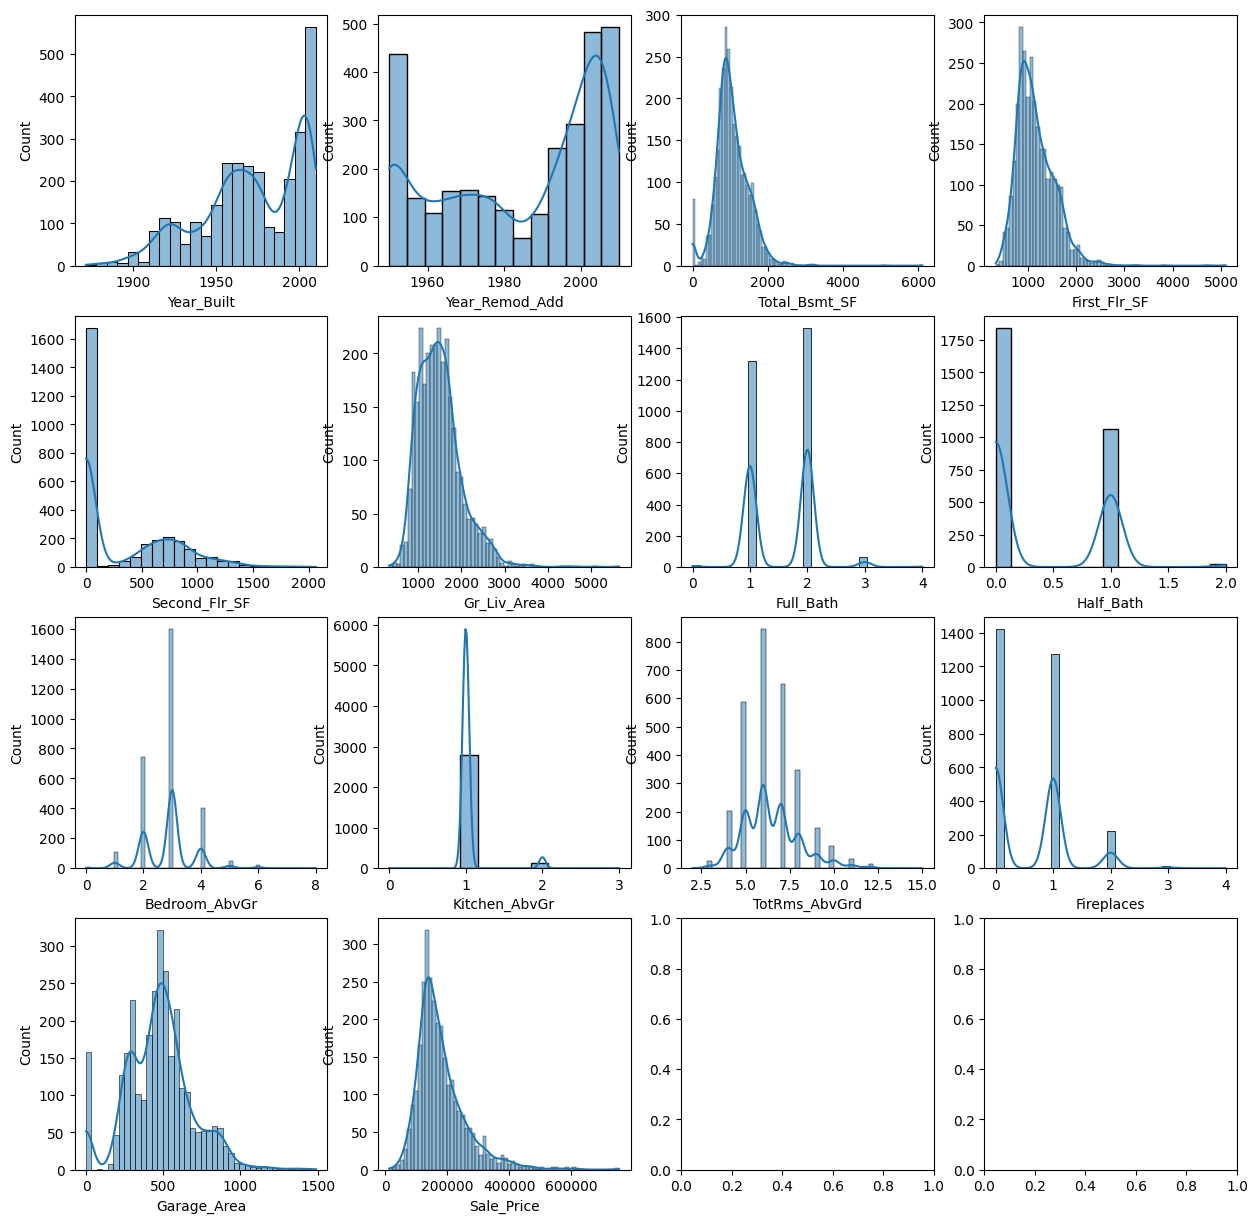

In [92]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for count, column in enumerate(data.columns):
    sns.histplot(data=data, x=column, kde=True, ax=axs[int(count/4), count%4])

In the figure above we can see how the data for each of the variables is distributed. 

We can see that some variables, such as `Total_Bsmt_SF` and `Gr_Liv_Area`, are approximatly normal distributions, while others are not.

We can also see that for some variables, such as `Kitchen_AbvGr`, almost all the records have the same value. In the case of `Kitchen_AbvGr`, this can be explained by the fact that most houses have just 1 kitchen. Those variables who's data is represented by just a few values are all discrete variables.

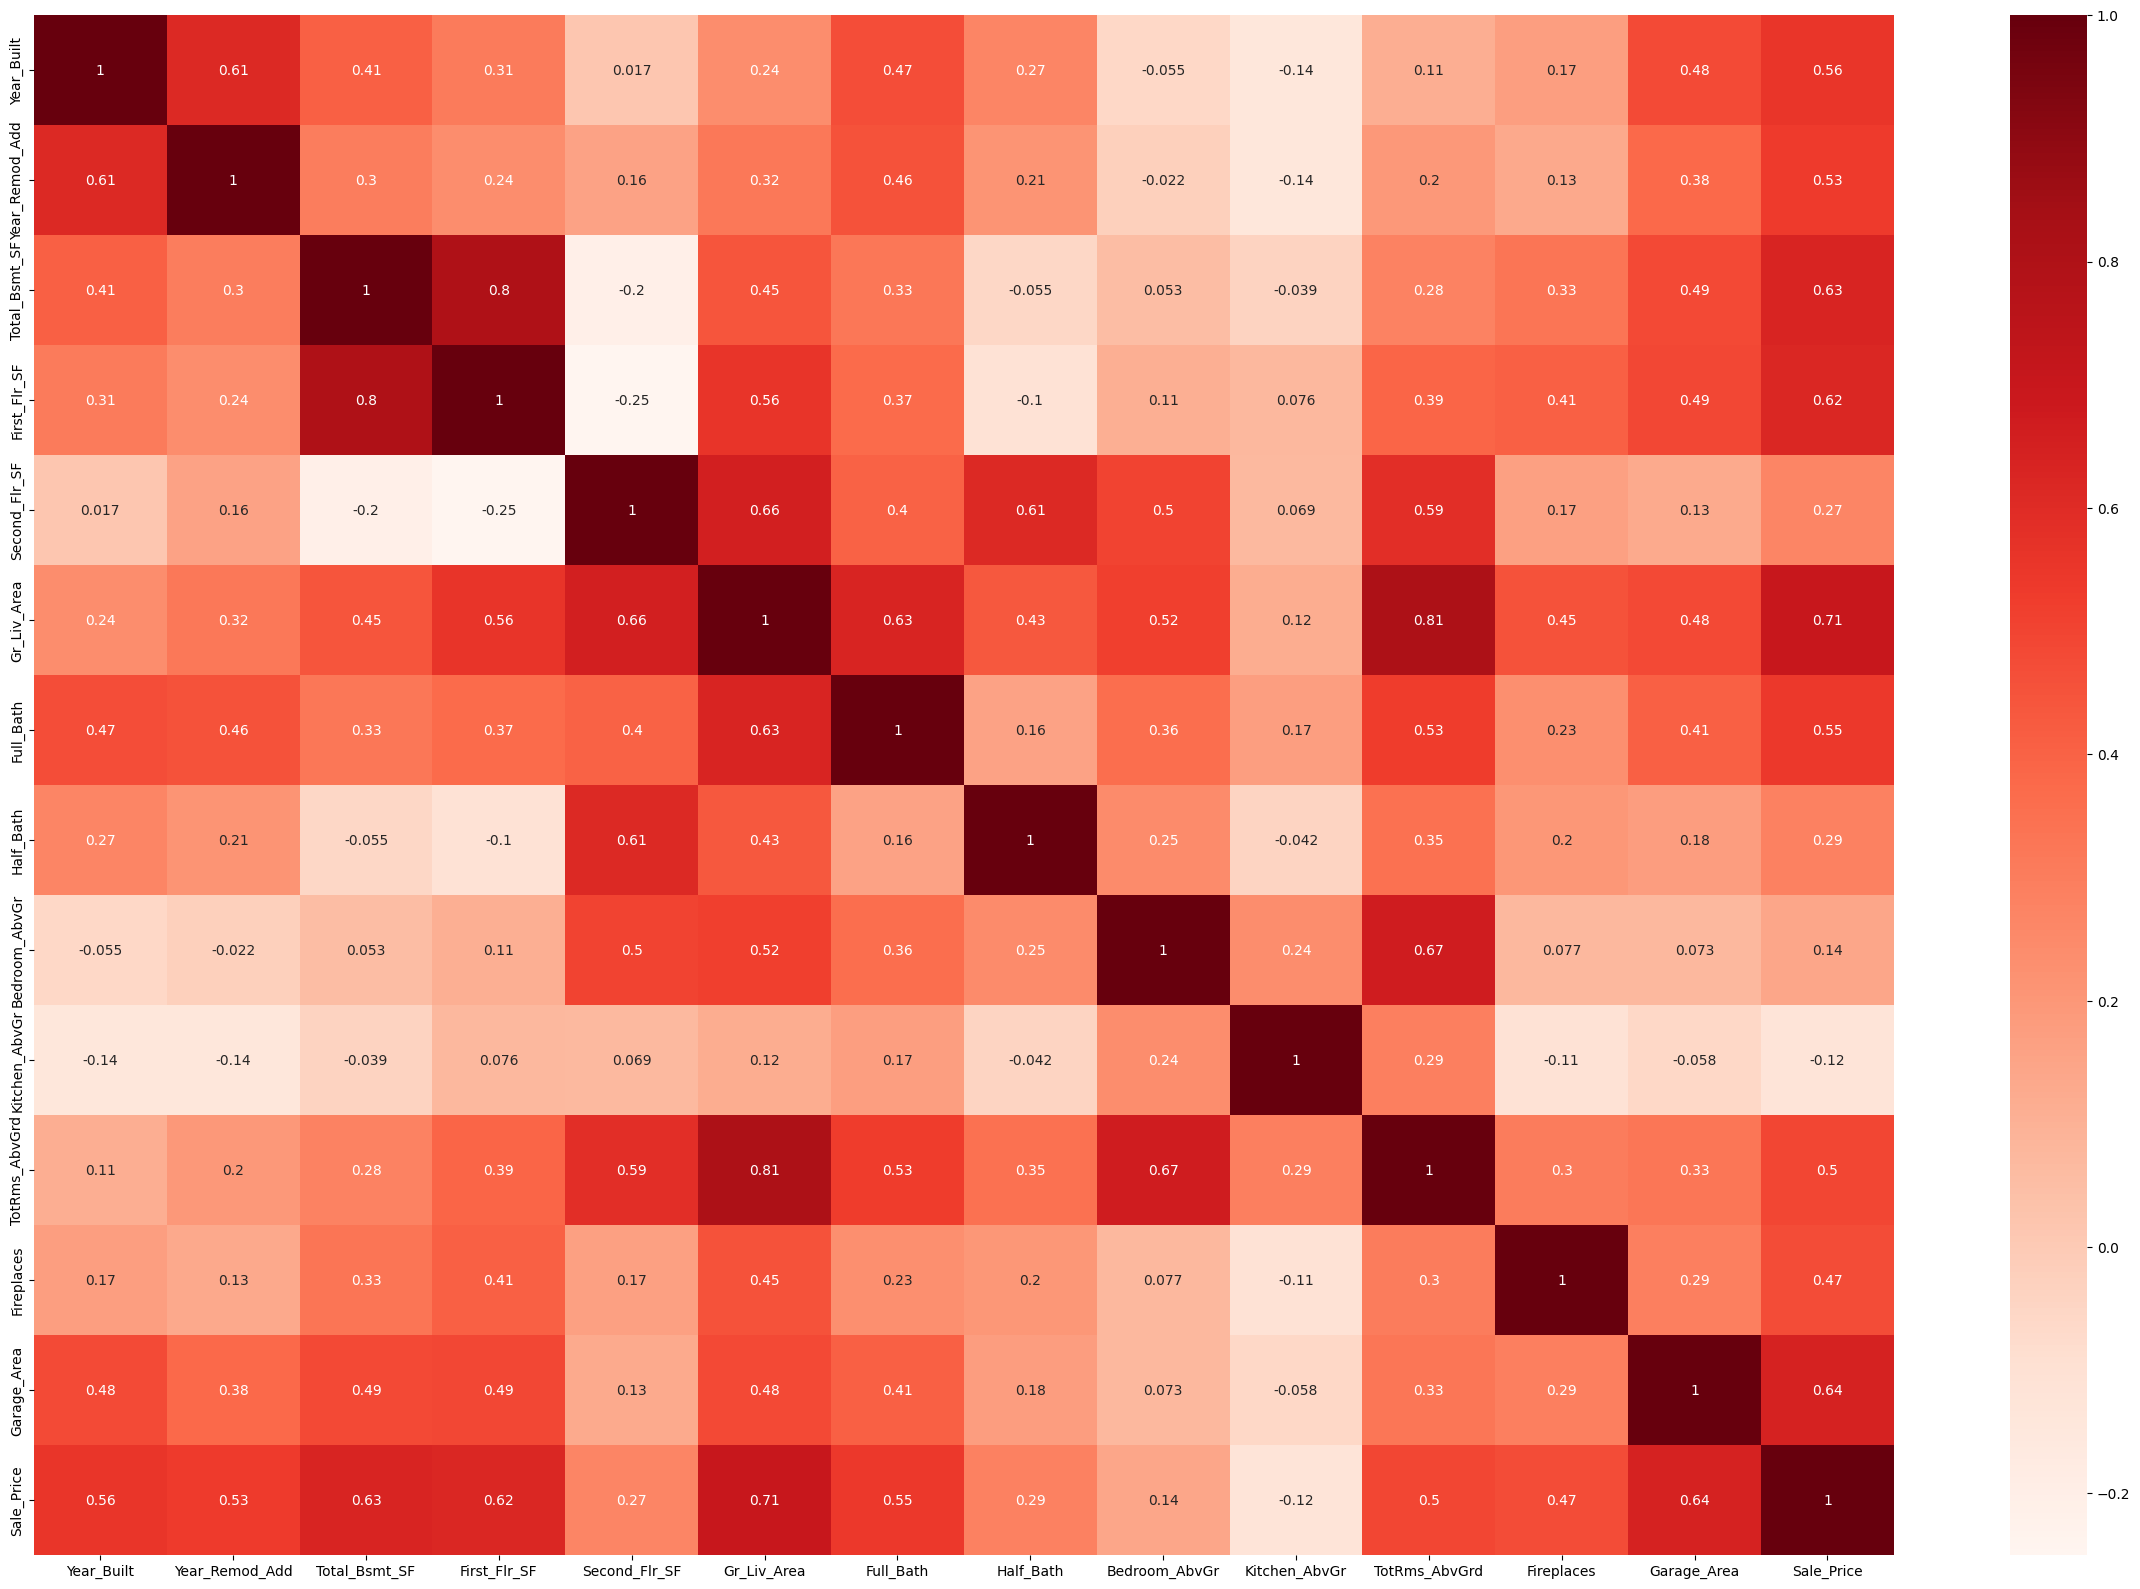

In [93]:
# Display Pearson correlation HeatMap
plt.figure(figsize=(30,20))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Here we are most interested to see the strength of the correlation between the `Sale_Price` and all the other variables. To do this we can look at the bottom row. 

We can see that most varaibles show a strong correlation with the sale price, with a few exceptions:
- `Kitchen_AbvGr` is showing as -0.12. This weak correlation is likely because almost all houses have just 1 kitchen. This can be seen in the histogram plot above.
- `Bedroom_AbvGr` is showing as 0.14. It is not immediatley clear why this is the case, as one would expect the number of bedrooms to correlate well with the house price. 

### Select variables

For the linear regression model use the following dependent variable:
- `Sale_Price`

and the following independent variables:
- `Gr_Liv_Area`: size of above grade, ground living area in square feet
- `Garage_Area`: size of garage in square feet

These variables have been selected since they have the higest correlation coefficents. 
The correlation coefficents for these variables, with `Sale_Price` are:
| Gr_Liv_Area | Garage_Area |
| ----------- | ----------- |
| 0.71 | 0.64 |

In [94]:
# Split the independent variable from the dependent variables
# y = dependent variable
# X = independent variables

y = data.iloc[:,-1].values
X = data.iloc[:,[5, 12]].values

### Explore relationships

Next we will check the relationships between the dependedent and independent variables and determine the need for scaling. 

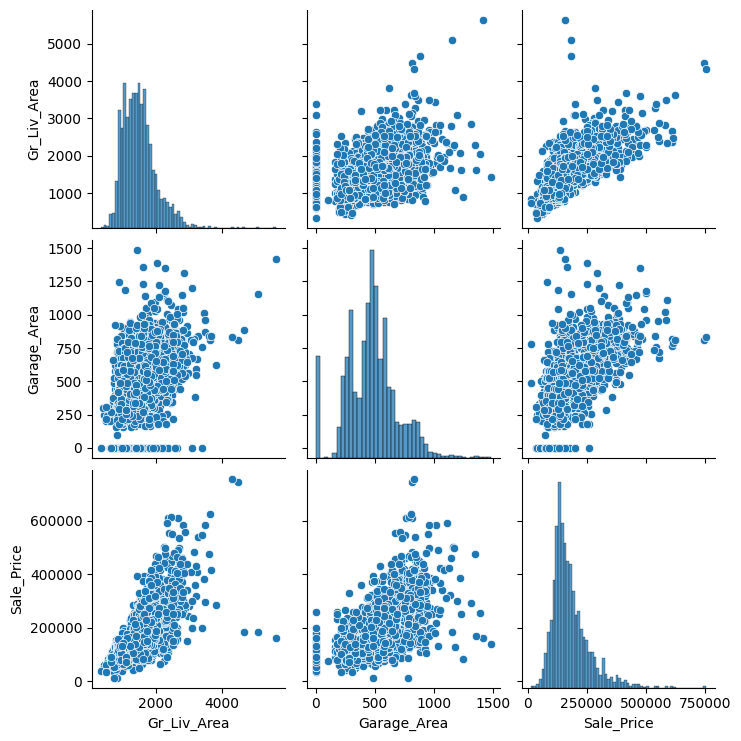

In [95]:
# Explore relationships between the independent and dependent variables

# Plot the distribution of the data
sns.pairplot(data=data.iloc[:,[5,12,13]])

Here we can see that the variables fit a normal distribution fairly well. The main exception to this is that there are a large number of zero values for `Garege_Area`. These represent houses that do not have a garage. Since these are genuine data points we will not ommit them from our analysis. 

We are now going to scale the data. This is necessary because each of the varaibles has different units and is on on a different scale. By scaling the data we ensure that each of the variables contributes equally to the linear regression model.

The two options for scaling data are standardization and normalization (Min-Max Scaling). 

Standardization is less affected by outliers and is best used when the data is normally distributed.

Normalization can be used for data that is not normally distributed but is heavily affected by outliers. 

Since the data is normally distributed, we will standardize using StandardScaler.


### Select datasets and scale data

Next we will select the datasets and scale the data.

In [96]:
# Create a training and test set with a 75:25 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

Training data: (2197, 2) (2197,)
Test data: (733, 2) (733,)


In [97]:
# Fit the scaler on train data
scalar = StandardScaler()
scalar.fit(X_train)

# Apply the scaler on train and test data
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [98]:
# Build a multiple linear regression model using 'Gr_Liv_Area' and 'Garage_Area'

model = LinearRegression()
model.fit(X_train,y_train)


# Print the model intercept and coefficients

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 179658.24578971326
Coefficients: 
 [39653.84321919 29739.14095719]


In [99]:
# Generate predictions for the test set
y_predictions = progression_model.predict(X_test)

# Get values for the error bar
error_bar_values = np.abs((y_test-y_predictions))

### Model evaluation
Here we evaluate the model by finding the root mean square of the error bar values.

In [127]:
# Calculate the mean squared error using mean_squared_error from sklearn.metrics
mse = mean_squared_error(y_test, y_predictions)
 
# Raise the mean squared error to the power of 0.5

rmse = (mse)**(1/2)
mean_y = sum(y)/len(y)

# Print the RMSE
print(f'root mean square error: ${round(rmse)}\n'
      f'mean sale price: ${round(mean_y)}\n'
      f'RMSE/mean: {round(100*rmse/mean_y)}%\n')

root mean square error: $50307
mean sale price: $180796
RMSE/mean: 28%



### Evaulation of the root mean square error
- The root mean square error (RMSE) is $46,867.
- When comparing this to the mean sale price of $180,796 we find that the RMSE is 26% of the mean.
- Whilst this RMSE is significant, it is low enough that our model is still valid for making predictions.

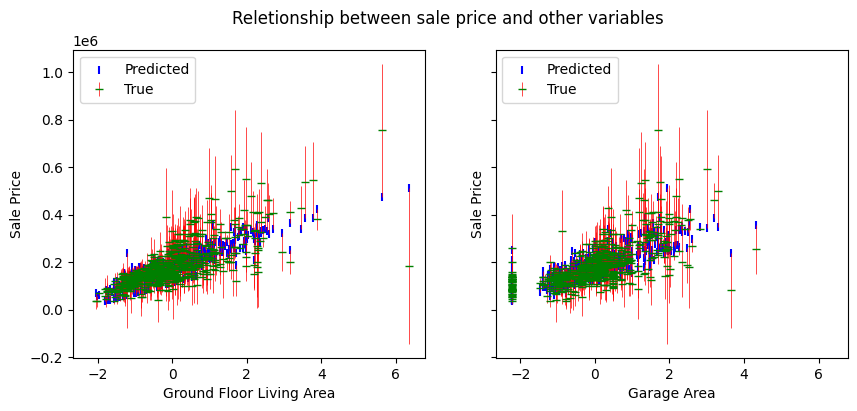

In [101]:
# Generate a plot
# Create container
fig, ax = plt.subplots(1, X_test.shape[1], sharey=True, sharex=True, figsize=(10,4))
fig.suptitle("Reletionship between sale price and other variables")
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Ground Floor Living Area')
ax[1].set_ylabel('Sale Price')
ax[1].set_xlabel('Garage Area')

# Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(X_test[:, i], y_test, yerr=error_bar_values, fmt='_g', ecolor='red', elinewidth=0.5 ,label='True')
    ax[i].scatter(X_test[:,i], y_predictions, c='b', marker='|', label='Predicted')
    ax[i].legend(loc='upper left')

In [121]:
# Print intercept and coefficents:

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

print(f'\nSale_Price = s_Gr_Liv_Area * {round(model.coef_[0])} + s_Garage_Area * {round(model.coef_[1])} + {round(model.intercept_)}')
print('Where s_Gr_Liv_Area and s_Garage_Area are standardised variables.')

# Print mean Sale_Price
median_sale_price = y[int(y.size/2)]
print(f'The median sale price is ${median_sale_price}.')

Intercept: 
 179658.24578971326
Coefficients: 
 [39653.84321919 29739.14095719]

Sale_Price = s_Gr_Liv_Area * 39654 + s_Garage_Area * 29739 + 179658
Where s_Gr_Liv_Area and s_Garage_Area are standardised variables.
The median sale price is $183000.


### Interpretation of the coefficients in the context of the prediction
#### Interpretion of the intercept
We can see from the values above that we have an intercept of approximatley $180k and a median of $183k. Since we have standardised our data to a normal distribution, the intercept of our regression model with the y-axis is equal to the mean of the y values from the training set. The mean value (£180k) and the median value ($183k) are similar, which is what we would expect for a dataset that fits a normal distribution model. 

#### Interpretation of the coefficents
From the values above we have a `Gr_Liv_Area` coefficent of 39654 and a `Garage_Area` coefficent of 29739. These coefficents tell us how much the sale price changes by when we move 1 standard deveation away from the mean of the x value. Since the coefficent for ground floor living area (`Gr_Liv_Area`) is larger, it has a more significant affect on the sale price than the garage area (`Garage_Area`). However the two values are similar to each other so the variable have a similar weighting in their effect on the sale price. 

If we divide these coefficents by the mean sale price, we can see the percentage by which the sale price changes when we move 1 standard deviation away from the mean x value. These values are shown below:

In [125]:
print(f'Gr_Liv_Area percentage change as we move 1 standard deviation from the mean: '
      f'{round(100*model.coef_[0]/model.intercept_)}%')
print(f'Garage_Area percentage change as we move 1 standard deviation from the mean: '
      f'{round(100*model.coef_[1]/model.intercept_)}%')

Gr_Liv_Area percentage change as we move 1 standard deviation from the mean: 22%
Gr_Liv_Area percentage change as we move 1 standard deviation from the mean: 17%


The vast majority of data points (95%) in a normal distribution lie within 2 standard deviations of the mean. We can see from these percentages that the sale price will change by 44% and 32% for ground floor living area and garage area respectively within this range.

### Summary of findings

The objective of this task was to analyse the relationship between the variables and build a multiple linear regression model to predict the sales prices based on the `Gr_Liv_Area` and `Garage_Area` variables.

First, we analysed the data to see if it needed cleaning. We found the data to be clean and ready to use. 

Next, we checked the distribution of the data for each of the 13 variables by plotting a series of hisyograms. This showed that some variables, including `Gr_Liv_Area` and `Garage_Area` followed a normal distribution, while others did not.

We then created a correlation heat map to show the strength of correlation between the variables, and specifically the strength of their correlation with the sale price. While many of the variables showed a strong correlation with the sale price, we limited our investiagtion to the two variables with the strongest correlation. These were `Gr_Liv_Area` and `Garage_Area` with correlations of 0.71 and 0.64 respectively. 

Following this, we explored the relatonships between the variables using `pairplot` and found that the data was best modelled uing a normal distribution. Based on this we decided to standardised the data once it had been split into training and test sets in a 75:25 ratio. The training data was then used to generate a linear regression model and this was then used to a root mean square error on the test data values. The root mean square error was approximatley $47k, which was 26% of the mean sale price, showing a significant error but one that is still acceptable for regression analysis. 

Finally we plotted the training data, test data and error bars on scatter plots and evaluated the intercept and coefficents, compared to the median Sale price. The intercept was found to be similar to the median sale price, as expected, and the coefficents were found to represent 22% and 17% of the median sale price for `Gr_Liv_Area` and `Garage_Area` respectively. Since the vast majority of data points (95%) in a normal distribution lie within 2 standard deviations of the mean, we can see from these percentages that the sale price will change by 44% and 32% for ground floor living area and garage area respectively within this range.